### A Simple Portfolio Allocation Problem

This example develops a very simple portfolio allocation problem. Real world portfolio allocation is complex!  A good exercise is reviewing this model (after we build it) and testing your modeling skills:  What aspects of the problem are not being modeled?  Are we modeling all the important aspects?  How much do you trust the solutions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

### Loading Data

I did the work of reading in the data for you so that you guys can focus on modeling.  Please read the code below and try to understand what it's doing. Ask questions!

In [2]:
#read monthly_ret_simple.csv using numpy, but ignore the first row and ignore first column
monthly_returns = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', skip_header=True)[:,1:]  

#read in just the first row of monthly_ret_simple.csv, ignore first column and label as tickers
tickers = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', max_rows=1, dtype=str) [1:]

#read in just the first column of monthly_ret_simple.csv, ignoring the first row and label as dates
dates = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', skip_header=True, usecols=0, dtype=str)

print(tickers)
print(dates)

#convert monthly_returns into a dictionary where
# the keys are pairs of (date, ticker) and values are the return
monthly_returns_dict = { (dates[i], tickers[j]) : monthly_returns[i,j] for i in range(len(dates)) for j in range(len(tickers)) }


['AAPL' 'ARKK' 'BABA' 'BITO' 'EEM' 'EWJ' 'FSLR' 'GLD' 'GRN' 'HASI' 'ICLN'
 'LIT' 'MSFT' 'NVDA' 'PLD' 'SWBI' 'TSLA' 'TSM' 'USO' 'VNO' 'VOO' 'XOM']
['20211201' '20220101' '20220201' '20220301' '20220401' '20220501'
 '20220601' '20220701' '20220801' '20220901' '20221001' '20221101'
 '20221201' '20230101' '20230201' '20230301' '20230401' '20230501'
 '20230601' '20230701' '20230801' '20230901' '20231001' '20231101'
 '20231201' '20240101']



"tickers", "dates" and "monthly_returns_dict" are goign to be our data in this problem. You'll only need to access those three from now on.

### Test your understanding.  

Answer the following questions about the data.

1. How many months of data do we have? 
2. How many assets are there?
3. Compute a dictionary (keys are tickers) with values equal to the average_return of the coresponding asset in the dataset.

In [3]:
# create a dictionary with keys as tickers and values as the average monthyl return for that ticker
avg_monthly_returns = { ticker : np.mean(monthly_returns[:,i]) for i, ticker in enumerate(tickers) }

print(avg_monthly_returns)

max_return = max(avg_monthly_returns.values())
max_return

{'AAPL': 0.007962174562988165, 'ARKK': -0.02173595572070678, 'BABA': -0.010382806866335357, 'BITO': 0.000590642684546822, 'EEM': -0.005079491470947254, 'EWJ': 0.00298429310119473, 'FSLR': 0.024968737500251328, 'GLD': 0.005752078658272582, 'GRN': -0.0021916739910450974, 'HASI': -0.01682302006508153, 'ICLN': -0.015419963112962409, 'LIT': -0.025713755364530057, 'MSFT': 0.010151493918484774, 'NVDA': 0.039998657444333036, 'PLD': 0.00030779600932548764, 'SWBI': -0.01001146798594438, 'TSLA': -0.009013664900598626, 'TSM': 0.007147300679139748, 'USO': 0.01802947653185009, 'VNO': -0.0005043382832834743, 'VOO': 0.005154818629344502, 'XOM': 0.028356495553137975}


0.039998657444333036

## On to the Actual Modeling!

Set parameter Username
Set parameter LicenseID to value 2609347
Academic license - for non-commercial use only - expires 2026-01-13
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 23.5.0 23F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 48 columns and 1240 nonzeros
Model fingerprint: 0x29ff3f7d
Coefficient statistics:
  Matrix range     [9e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 26 rows and 0 columns
Presolve time: 0.03s
Presolved: 28 rows, 48 columns, 642 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.559825e+00   0.000000e+00      0s

Solved in 19 iterations and 0.05 seconds (0.00 work units)
Infeasible model


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

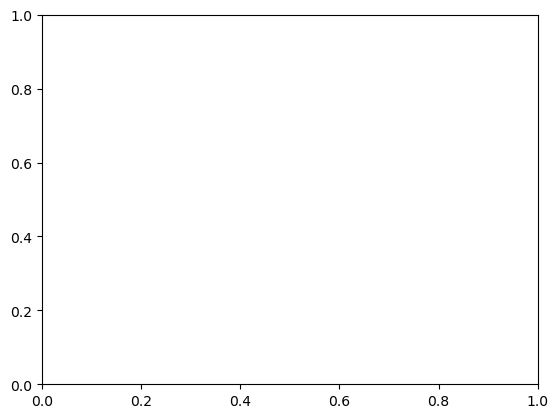

In [4]:
target_return_grid = np.linspace(0, max_return, 30)
optimal_risks = []

m = Model("portfolio")

target_return = 0.01

# Decision Variables
x = m.addVars(tickers, lb=0, name="t")
d = m.addVars(dates, lb = 0, name="d")

# Constraints

# add a constraint so that the sum of the portfolio is equal to 100%
m.addConstr((quicksum(x[i] for i in tickers) == 1), name="portfolio_sum")

# add a constrain so that the sum of the average monthly returns is greater than or equal to the target return
m.addConstr(quicksum(x[i] * avg_monthly_returns[i] for i in tickers) >= target_return, name="target_return")

# add a constraint for the absolute mean deviation of returns
for t in dates:
    m.addConstr(quicksum(x[i] * monthly_returns_dict[(t, i)] for i in tickers) - d[t] <= 0, name=f"abs_mean_dev_{t}")
    m.addConstr(-quicksum(x[i] * monthly_returns_dict[(t, i)] for i in tickers) + d[t] <= 0, name=f"abs_mean_dev_{t}")

m.setObjective(quicksum(d[t] for t in dates), GRB.MINIMIZE)

m.optimize()


### What happens if you ask for a target return of 10%?

Does this make sense?  what's the largest target return you can ask for?  You can either reason about this, or modify our optimization problem to compute it!  What's the minimal return you could ask for?

### Pareto Curve


There should be a tradeoff between risk and reward.  The larger the target_reward I require, the more risk I must have to accept.  In the next part of the problem, we're looking ot make a plot with the x-axis as the target_reward, and the y-axis as the risk.

### How does this connect to Sensitivity analysis?
Pick a value on the plot, say target_reward = 0.025.  Compute the sensitivity analysis table at that point.  Can you use this table to determine the slope of your plot at target_reward = 0.25?  Where do you expect the next kink is?